In [29]:
# Limpieza de la base de datos
import pandas as pd
import numpy as np

df = pd.read_csv(  # Lectura de datos
    "../data/BBDD Población Chile (1b).xlsx - Tabla ajustada población .csv",
    index_col=0
)


df = df.T  # Transposicion

# notacion europea a float
for col in df.columns:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
    )

df = df.replace(["NaN", "nan", "NAN", "None", ""], np.nan)
df = df.fillna(0)

df = df.apply(pd.to_numeric)




print(df)

df.to_csv("../data/output.csv")

      Población total de jovenes (0-14)  Población total de adultos (15-64)  \
2002                          4156812.0                          10288683.0   
2003                          4116188.0                          10456445.0   
2004                          4057629.0                          10640163.0   
2005                          3991476.0                          10826184.0   
2006                          3921521.0                          11017529.0   
2007                          3864328.0                          11200341.0   
2008                          3823083.0                          11375175.0   
2009                          3792259.0                          11541067.0   
2010                          3767767.0                          11697176.0   
2011                          3748933.0                          11851404.0   
2012                          3732105.0                          11998670.0   
2013                          3712426.0             

In [50]:
#regresion
import statsmodels.api as sm

x_J=df[["Población total de adultos (15-64)","Población total de jovenes (0-14)"]]
y_J=df["dJ"]

x_J=sm.add_constant(x_J)
modelo_J = sm.OLS(y_J,x_J).fit()



x_A=df[["Población total de jovenes (0-14)","Población total de adultos (15-64)"]]
y_A=df["dA"]
x_A=sm.add_constant(x_A)
modelo_A=sm.OLS(y_A,x_A).fit()

x_E=df[["Poblacion total mayores (65+ años)"]]
y_E=df["dM"]
x_E=sm.add_constant(x_E)
modelo_E=sm.OLS(y_E,x_E).fit()

print(modelo_J.summary())
print(modelo_A.summary())
print(modelo_E.summary())


                            OLS Regression Results                            
Dep. Variable:                     dJ   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     8.693
Date:                Tue, 11 Nov 2025   Prob (F-statistic):            0.00192
Time:                        14:18:33   Log-Likelihood:                -258.75
No. Observations:                  23   AIC:                             523.5
Df Residuals:                      20   BIC:                             526.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

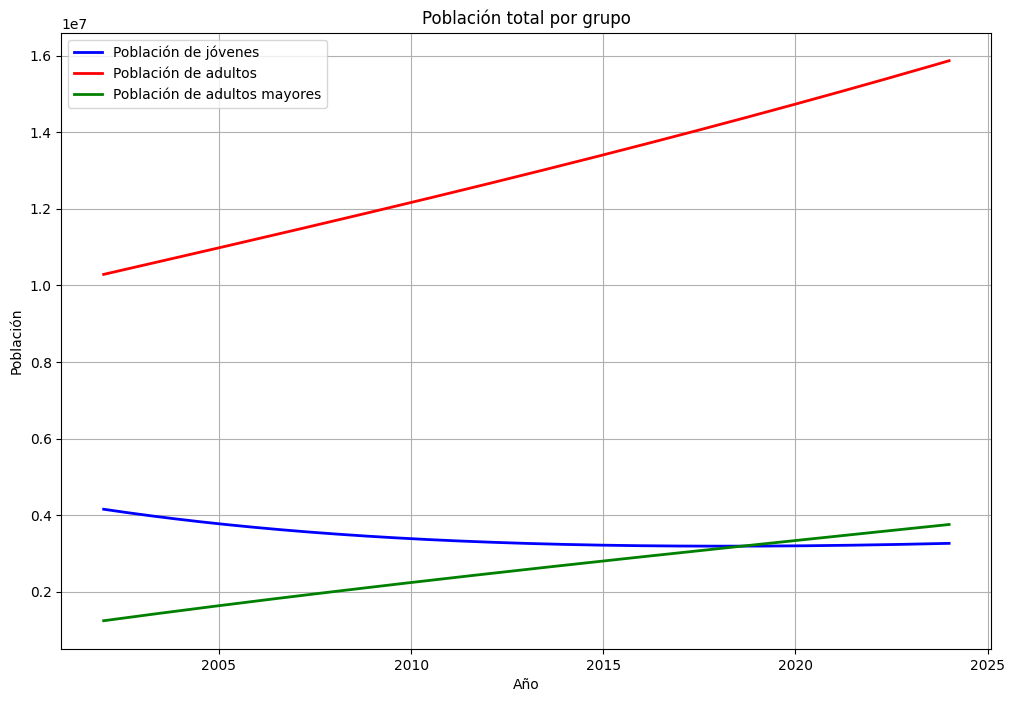

In [51]:
# Graficación por Runge-Kutta 4 (consistente en el orden del estado)
import numpy as np
import matplotlib.pyplot as plt

def sistema_edos(t, y):
    # y = [J, A, E]
    jt, at, et = y

    # COEFICIENTES
    c1 = 0.0181  # tasa de natalidad
    c2 = 0.0140  # tasa de mortalidad jóvenes
    c3 = -0.0343  # tasa de mortalidad adultos (positiva)
    c4 = 0.0567  # tasa de mortalidad mayores

    # ECUACIONES
    dyJ = c1*at - c2*jt - (1/15)*jt
    dyA = (1/50)*jt - c3*at - (1/50)*at
    dyE = (1/50)*at - c4*et
    return [dyJ, dyA, dyE]

def RK4(func, y0, t0, tf, h):
    t_values = np.arange(t0, tf + h, h)
    n = len(t_values)
    y_values = np.zeros((n, len(y0)), dtype=float)
    y_values[0] = y0

    for i in range(1, n):
        k1 = np.array(func(t_values[i-1], y_values[i-1]))
        k2 = np.array(func(t_values[i-1] + h/2, y_values[i-1] + h*k1/2))
        k3 = np.array(func(t_values[i-1] + h/2, y_values[i-1] + h*k2/2))
        k4 = np.array(func(t_values[i-1] + h,   y_values[i-1] + h*k3))
        y_values[i] = y_values[i-1] + h*(k1 + 2*k2 + 2*k3 + k4)/6

    return t_values, y_values

# y0 = [J, A, E] en 2002
y0 = [4156812.0, 10288683.0, 1246206.0]
t0, tf, h = 0, 22, 0.01

t, y = RK4(sistema_edos, y0, t0, tf, h)

years = 2002 + t
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(years, y[:, 0], 'b-', linewidth=2, label='Población de jóvenes')
ax.plot(years, y[:, 1], 'r-', linewidth=2, label='Población de adultos')
ax.plot(years, y[:, 2], 'g-', linewidth=2, label='Población de adultos mayores')
ax.set_title('Población total por grupo')
ax.set_xlabel('Año')
ax.set_ylabel('Población')
ax.grid(True)
ax.legend()
plt.show()